In [2]:
pip install pandas numpy scikit-learn matplotlib joblib


Note: you may need to restart the kernel to use updated packages.


In [16]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
data_path = "~/Desktop/acs2023_immigrants_clean_rebuilt.csv"

df = pd.read_csv(data_path)
df.head()

#Binary target: employed vs not employed
df["esr"].value_counts()

esr
 1    57604
 6    34257
-1     4133
 3     2394
 2     1371
 4      238
 5        3
Name: count, dtype: int64

In [38]:
# 1 = Employed at work
# 2 = Employed but absent
df["employed_binary"] = df["esr"].isin([1, 2]).astype(int)

# Check distribution
df["employed_binary"].value_counts(normalize=True)



employed_binary
1    0.58975
0    0.41025
Name: proportion, dtype: float64

In [39]:
# Correct feature list for rebuilt dataset
feature_cols = ["schl", "eng", "cit", "agep", "sex", "puma"]
target_col = "employed_binary"

# Create model dataframe
df_model = df[feature_cols + [target_col]].dropna()

# Features & target
X = df_model[feature_cols]
y = df_model[target_col]

X.shape, y.shape



((100000, 6), (100000,))

In [59]:
#Train-test split (with stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

#Naive Baseline
import numpy as np

# Check class balance
print("Class distribution in y_test:")
print(y_test.value_counts(normalize=True))

# Baseline: always predict the majority class
majority_class = y_train.mode()[0]  # usually 1 for employed

y_pred_baseline = np.full_like(y_test, fill_value=majority_class)

from sklearn.metrics import accuracy_score

baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print("Baseline (majority class) accuracy:", baseline_accuracy)


Class distribution in y_test:
employed_binary
1    0.58975
0    0.41025
Name: proportion, dtype: float64
Baseline (majority class) accuracy: 0.58975


In [60]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_features = ["agep"]
categorical_features = ["schl", "eng", "cit", "sex", "puma"]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

#Missing data
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])


Logistic Regression Performance:
Accuracy: 0.6803
Precision: 0.7425671427288242
Recall: 0.7008902077151336
F1: 0.7211270062805304

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.65      0.63      8205
           1       0.74      0.70      0.72     11795

    accuracy                           0.68     20000
   macro avg       0.67      0.68      0.67     20000
weighted avg       0.68      0.68      0.68     20000



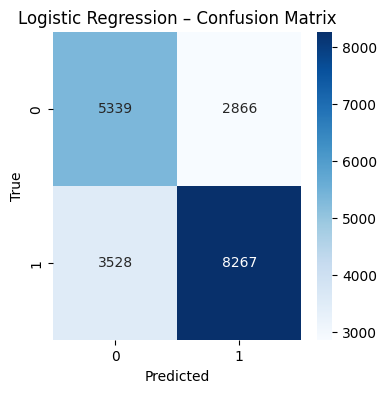

In [61]:
#Model 1

#Pipeline
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"  # helps with imbalance
)

log_reg_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", log_reg)
    ]
)

#Train model
log_reg_pipeline.fit(X_train, y_train)

#Evaluate on test set
y_pred_lr = log_reg_pipeline.predict(X_test)

print("Logistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("F1:", f1_score(y_test, y_pred_lr))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))


#Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(4, 4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Logistic Regression – Confusion Matrix")
plt.show()

#plt.savefig("../reports/figures/confusion_matrix_logistic.png", bbox_inches="tight", dpi=300)



Logistic Regression ROC–AUC: 0.7327880801391019
Random Forest ROC–AUC: 0.8197655819932169


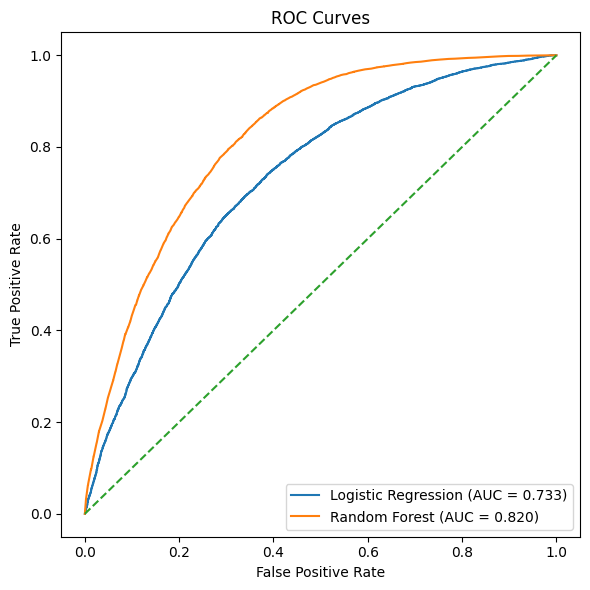

In [66]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

#Predicted probabilities for the positive class
y_proba_lr = log_reg_pipeline.predict_proba(X_test)[:, 1]
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

# ROC–AUC scores
auc_lr = roc_auc_score(y_test, y_proba_lr)
auc_rf = roc_auc_score(y_test, y_proba_rf)

print("Logistic Regression ROC–AUC:", auc_lr)
print("Random Forest ROC–AUC:", auc_rf)

#ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(6, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")  # diagonal random line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.tight_layout()
plt.show()


Random Forest Performance:
Accuracy: 0.7597
Precision: 0.7795376369890409
Recall: 0.8261975413310725
F1: 0.8021896608495226

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.66      0.69      8205
           1       0.78      0.83      0.80     11795

    accuracy                           0.76     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.76      0.76      0.76     20000



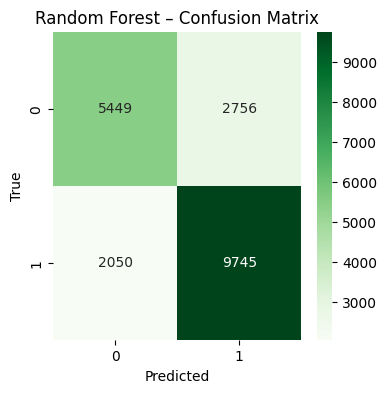

In [62]:
#Model 2 -- Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

rf_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", rf)
    ]
)

#Train
rf_pipeline.fit(X_train, y_train)

#Evaluate
y_pred_rf = rf_pipeline.predict(X_test)

print("Random Forest Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1:", f1_score(y_test, y_pred_rf))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

#Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(4, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Random Forest – Confusion Matrix")
plt.show()

#plt.savefig("../reports/figures/confusion_matrix_rf.png", bbox_inches="tight", dpi=300)



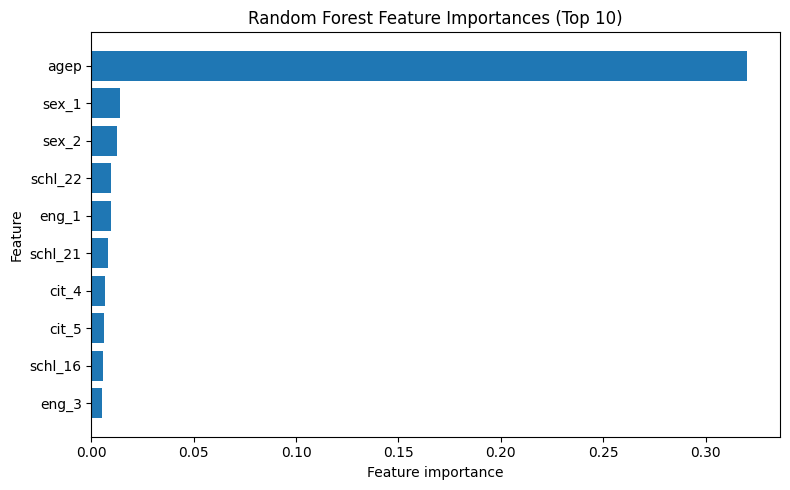

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Extracting trained random forest and preprocessor from the pipeline
rf_model = rf_pipeline.named_steps["model"]
preprocessor = rf_pipeline.named_steps["preprocess"]

ohe = preprocessor.named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)

all_feature_names = np.concatenate([numeric_features, cat_feature_names])

#Building a DataFrame of importances
importances = rf_model.feature_importances_
fi_df = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

fi_df.head(15)  # inspect top 15 features

#Bar plot
top_n = 10
top_feats = fi_df.head(top_n).sort_values("importance")  # sort so smallest at top

plt.figure(figsize=(8, 5))
plt.barh(top_feats["feature"], top_feats["importance"])
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances (Top 10)")
plt.tight_layout()
plt.show()


In [63]:
#Comparing Models
results = {
    "model": ["logistic_regression", "random_forest"],
    "accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf)
    ],
    "precision": [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_rf)
    ],
    "recall": [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_rf)
    ],
    "f1": [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf)
    ]
}

results_df = pd.DataFrame(results)
results_df

#results_df.to_csv("../results/metrics_summary.csv", index=False)

,model,accuracy,precision,recall,f1
0,logistic_regression,0.6803,0.742567,0.700890,0.721127
1,random_forest,0.7597,0.779538,0.826198,0.802190


In [64]:
import joblib
from pathlib import Path

# Create a writable folder in your home directory
models_dir = Path("/Users/magdalya/immigration_models")
models_dir.mkdir(parents=True, exist_ok=True)

# Save your models there
joblib.dump(log_reg_pipeline, models_dir / "logistic_model.joblib")
joblib.dump(rf_pipeline, models_dir / "random_forest_model.joblib")




['/Users/magdalya/immigration_models/random_forest_model.joblib']

In [31]:
df.head()

,PUMA,AGEP,SEX,SCHL,NATIVITY,CIT,ENG,ESR,WAGP,RAC1P,HISP,SEX_LABEL,CIT_LABEL,ENG_LABEL,ESR_LABEL
0,1100,45,2,17.0,2,5,NaN,6.0,30000.0,1,24,Female,Not a citizen,NaN,Not in labor force
1,1100,24,1,19.0,2,5,NaN,6.0,0.0,6,1,Male,Not a citizen,NaN,Not in labor force
2,2400,53,1,13.0,2,4,2.0,6.0,0.0,9,2,Male,Naturalized citizen,Very well,Not in labor force
3,1901,37,1,19.0,2,5,2.0,6.0,32100.0,8,2,Male,Not a citizen,Very well,Not in labor force
4,1502,24,1,19.0,2,5,NaN,6.0,0.0,6,1,Male,Not a citizen,NaN,Not in labor force
